This IPython Notebook is intended to validate the parameters in the C5G7-TD Benchmark specification by calculating them using the provided isotopic data. The data to be validated includes:

* 7-energy-group Transport, Absorption, Capture, Velocity, and Scatter matrix for each material.
* Fission, Nu, and Chi for each fissile material.
* 8-delayed-group delayed neutron fractions, precursor decay constants, and delayed neutron spectra for each fuel material.

## Generate Input Files

In [1]:
import math
import pickle
import matplotlib
from copy import deepcopy

from IPython.display import Image
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import os

import openmc
import openmc.mgxs
import openmc.plotter
import openmc.kinetics as kinetics

from geometry import materials, surfaces, universes, cells, lattices, geometry
from plots import plots
from mgxs_lib import mgxs_data

%matplotlib inline

We will start by exporting the geometry and materials files to xml.

In [2]:
# Create the materials file
materials_file = openmc.Materials(geometry.get_all_materials())

# Adjust the moderator densities
materials['Moderator Bank 1'].density = 

# Adjust the cells to have the desired translations
cells['Control Rod Base Bank 1'].translation = [0., 0., 64.26]
#cells['Control Rod Base Bank 1'].translation = [[0., 0., 64.26],
#                                                [0., 0., 21.42],
#                                                [0., 0., 64.26]]
#cells['Control Rod Base Bank 1'].translation_times = [0., 2., 4.]
cells['Control Rod Base Bank 2'].translation = [0., 0., 64.26]
cells['Control Rod Base Bank 3'].translation = [0., 0., 64.26]
cells['Control Rod Base Bank 4'].translation = [0., 0., 64.26]

With the geometry and materials finished, we can define simulation parameters. In this case, we will use 100 inactive batches and 100 active batches each with 5000 particles.

In [3]:
# OpenMC simulation parameters
batches = 20
inactive = 10
particles = 1000

# Instantiate a Settings object
settings_file = openmc.Settings()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles
settings_file.output = {'tallies': False}

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-32.13, -10.71, -64.26, 10.71,  32.13,  64.26]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.source.Source(space=uniform_dist)

settings_file.entropy_lower_left  = bounds[:3]
settings_file.entropy_upper_right = bounds[3:]
settings_file.entropy_dimension   = [34,34,1]

## Create an MGXS Library

Now we are ready to generate multi-group cross sections! First, let's define the ANL and WIMS-D 7-group structures using the built-in `EnergyGroups` class.

In [4]:
# Instantiate a 50-group EnergyGroups object
fine_groups = openmc.mgxs.EnergyGroups()
fine_groups.group_edges = [0., 0.13, 0.63, 4.1, 55.6, 9.2e3, 1.36e6, 2.0e7]
#fine_groups.group_edges = [0., 2.0e7]

# Instantiate a 2-group EnergyGroups object
energy_groups = openmc.mgxs.EnergyGroups()
#energy_groups.group_edges = [0., 0.13, 0.63, 4.1, 55.6, 9.2e3, 1.36e6, 2.0e7]
energy_groups.group_edges = [0., 55.6, 2.0e7]

# Instantiate a 1-group EnergyGroups object
one_group = openmc.mgxs.EnergyGroups()
one_group.group_edges = [fine_groups.group_edges[0], fine_groups.group_edges[-1]]

In addition, we instantiate a kappa-fission tally to plot the axially-integrated pin powers.

In [5]:
# Create pin cell mesh 
mesh = openmc.Mesh()
mesh.type = 'regular'
mesh.dimension = [1,1,1]
mesh.lower_left  = [-32.13, -10.71, -85.68]
mesh.width = [42.84/1, 42.84/1, 171.36/1]

pin_cell_mesh = openmc.Mesh()
pin_cell_mesh.type = 'regular'
pin_cell_mesh.dimension = [34,34,1]
pin_cell_mesh.lower_left  = [-32.13, -10.71, -85.68]
pin_cell_mesh.width = [42.84/34, 42.84/34, 171.36/1]

assembly_mesh = openmc.Mesh()
assembly_mesh.type = 'regular'
assembly_mesh.dimension = [2,2,1]
assembly_mesh.lower_left  = [-32.13, -10.71, -85.68]
assembly_mesh.width = [42.84/2, 42.84/2, 171.36/1]

# Instantiate a clock object
clock = openmc.kinetics.Clock(start=0., end=10., dt_outer=1.e-1, dt_inner=1.e-2)

# Instantiate a kinetics solver object
solver = openmc.kinetics.Solver(name='Case 4-1', directory='C5G7')
solver.num_delayed_groups           = 8
solver.mesh                         = mesh
solver.pin_cell_mesh                = pin_cell_mesh
solver.assembly_mesh                = assembly_mesh
solver.one_group                    = one_group
solver.energy_groups                = energy_groups
solver.fine_groups                  = fine_groups
solver.geometry                     = geometry
solver.settings_file                = settings_file
solver.materials_file               = materials_file
solver.clock                        = clock
solver.core_volume                  = 42.84 * 42.84 * 128.52
solver.constant_seed                = True
solver.chi_delayed_by_delayed_group = True
solver.chi_delayed_by_mesh          = False
solver.use_pregenerated_sps         = False

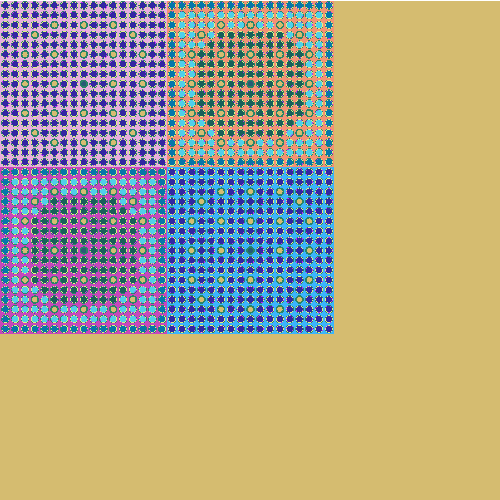

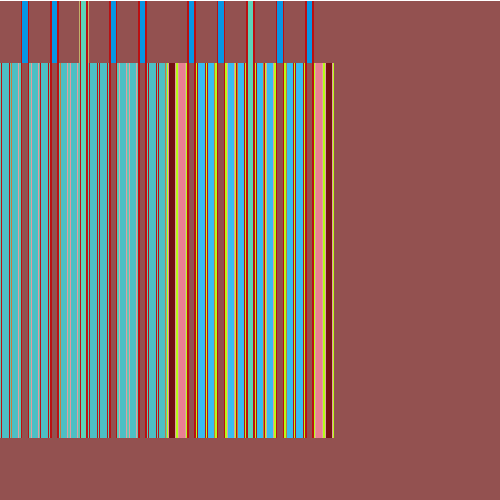

In [6]:
# Create the plots file
if not os.path.exists(solver.run_directory):
    os.makedirs(solver.run_directory)
    
plot_file = openmc.Plots(plots.values())
plot_file.export_to_xml(path=solver.run_directory + '/plots.xml')
geometry.export_to_xml(path=solver.run_directory + '/geometry.xml')
materials_file.export_to_xml(path=solver.run_directory + '/materials.xml')

# Run openmc in plotting mode
openmc.plot_geometry(output=False, cwd=solver.run_directory)

# Convert OpenMC's funky ppm to png
!convert C5G7/Case\ 4-1/materials-xy.ppm C5G7/Case\ 4-1/materials-xy.png
!convert C5G7/Case\ 4-1/materials-xz.ppm C5G7/Case\ 4-1/materials-xz.png

# Display the materials plot inline
x = Image(filename='C5G7/Case 4-1/materials-xy.png') 
y = Image(filename='C5G7/Case 4-1/materials-xz.png') 
display(x, y)

In [7]:
# Run OpenMC
solver.compute_initial_flux()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

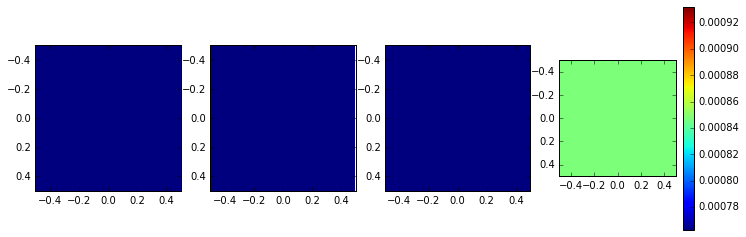

In [8]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)


level = 0
g = 0

flux = deepcopy(solver.states['START'].flux)
flux = flux / flux.sum() * np.prod(mesh.dimension)
flux.shape = mesh.dimension[::-1] + [solver.ng]
im1 = ax1.imshow(flux[level,...,g],interpolation='none')

flux_openmc = solver.states['START'].mgxs_lib['absorption'].tallies['flux'].get_values()
flux_openmc.shape = mesh.dimension[::-1] + [solver.ng]
flux_openmc = flux_openmc[..., ::-1]
flux_openmc = flux_openmc / flux_openmc.sum() * np.prod(mesh.dimension)
im2 = ax2.imshow(flux_openmc[level,...,g],interpolation='none')

adj_flux = deepcopy(solver.states['START'].adjoint_flux)
adj_flux = adj_flux / flux.sum() * np.prod(mesh.dimension)
adj_flux.shape = mesh.dimension[::-1] + [solver.ng]
im3 = ax3.imshow(adj_flux[level,...,g],interpolation='none')

#flux_dif = np.abs((flux - flux_openmc) / flux_openmc) * 100.
flux_dif = (flux - flux_openmc)
im4 = ax4.imshow(flux_dif[level,...,g],interpolation='none')
fig.colorbar(im4)

In [9]:
for i in range(3):
    solver.take_outer_step()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

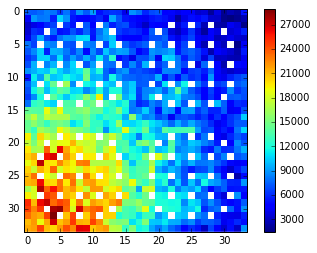

In [10]:
pin_powers = solver.pin_powers[0]
for pp in solver.pin_powers[1:]:
    pin_powers += pp
pin_powers = pin_powers.sum(axis=0)
pin_powers[pin_powers == 0.] = np.nan
plt.imshow(pin_powers, interpolation='none')
plt.colorbar()